In [1]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

2023-10-09 12:55:57.264467: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-09 12:55:57.436468: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 12:55:57.436497: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 12:55:57.437158: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 12:55:57.488120: I tensorflow/core/platform/cpu_feature_g

In [2]:
# Check if TensorFlow can access any GPU devices
gpu_devices = tf.config.list_physical_devices('GPU')

if len(gpu_devices) == 0:
    print("No GPU devices found.")
else:
    print(f"GPU devices found: {gpu_devices}")

# Check which GPU device is currently being used (if any)
current_gpu_device = tf.test.gpu_device_name()
if current_gpu_device:
    print(f"Current GPU device: {current_gpu_device}")
else:
    print("No GPU device is currently being used.")

# Check if GPU acceleration is available for TensorFlow
if tf.test.is_built_with_cuda():
    print("TensorFlow is built with CUDA support (GPU acceleration).")
else:
    print("TensorFlow is not built with CUDA support (GPU acceleration).")

    
print(tf.config.list_physical_devices('GPU'))

GPU devices found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Current GPU device: /device:GPU:0
TensorFlow is built with CUDA support (GPU acceleration).
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-10-09 12:56:02.061001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-09 12:56:02.123640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-09 12:56:02.123791: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4" 

In [4]:
df = pd.read_csv('sk_dataset/slovak_data4_preprocessed.csv')
df.head()

,Unnamed: 0,tweet,label
0,29,Marek Koolily hovorí s jasnejšími a faktami.,0
1,30,Vyhýbal som sa parlamentným voľbám už veľmi dlho,0
2,31,Tak,0
3,33,Nech vás Boh žehná za prezidenta Zuzana Capputová,0
4,34,Je to tiež osoba na správnom mieste.Ľudia nás ...,0


In [95]:
#Check the last dataset
off_df = df[df['label'] == 1]
non_off_df = df[df['label'] == 0]
off_df.shape, non_off_df.shape

((13158, 3), (13150, 3))

In [6]:
X_train, X_val, y_train, y_val = train_test_split(df['tweet'],
                                                  df['label'],
                                                  test_size=0.2,
                                                  random_state=22, shuffle=True, stratify=df['label'])

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((21046,), (5262,), (21046,), (5262,))

In [7]:
# Load the bert encoder model
bert_preprocess = hub.load(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

2023-10-09 12:58:11.161917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-09 12:58:11.162148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-09 12:58:11.162223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [20]:
# Defining the model
def bert_based_model(dropout_rate=0.1):
    # Bert layers
    input_text = tf.keras.layers.Input(shape=(), dtype=tf.string, name='inputs')

    # Create a KerasLayer for tokenization
    tokenize = hub.KerasLayer(bert_preprocess.tokenize)
    tokenized_inputs = tokenize(input_text)

    tokenized_inputs.shape

    # Pack input sequences for the Transformer encoder (if needed)
    seq_length = 128  
    bert_pack_inputs = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length)) 

    encoder_inputs = bert_pack_inputs([tokenized_inputs])
    outputs = bert_encoder(encoder_inputs)

    # Neural network layers
    layer = tf.keras.layers.Dropout(dropout_rate)(outputs["pooled_output"])  # Dropout layer
    layer = tf.keras.layers.Dense(1, activation="relu")(layer)
    layer = tf.keras.layers.Dropout(dropout_rate)(layer)

    # Output layer for binary classification
    output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(layer)

    # Use inputs and outputs to construct a final model
    model = tf.keras.Model(inputs=[input_text ], outputs = [output])
    return model
model = bert_based_model()


In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None,)]                    0         []                            
                                                                                                  
 keras_layer_5 (KerasLayer)  (None, None, None)           0         ['inputs[0][0]']              
                                                                                                  
 keras_layer_6 (KerasLayer)  {'input_mask': (None, 128)   0         ['keras_layer_5[0][0]']       
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                      

In [22]:
import os
checkpoint_dir = "checkpoints/checkpoints_mul/sk_checkpoint"

# creates the folder if not exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir, mode = 0o777)

checkpoint_file_format = os.path.join(checkpoint_dir, "model_epoch_{epoch:02d}--loss-{loss:.4f}.h5")

# Create a ModelCheckpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_format,
    save_weights_only=True,  # Save only the model's weights
    save_best_only=True,     # Save the best one
    monitor="loss",          # Monitor loss
    mode="auto",             # Auto-detect whether to minimize or maximize the monitored metric
    verbose=1)               # Show progress during training


#Compile the model
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

# Learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=METRICS)

In [23]:
model.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=[model_checkpoint_callback] )

Epoch 1/10
658/658 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.5995 - precision: 0.5864 - recall: 0.6762
Epoch 1: loss improved from inf to 0.67376, saving model to checkpoints/checkpoints_mul/sk_checkpoint/model_epoch_01--loss-0.6738.h5
658/658 [==============================] - 231s 348ms/step - loss: 0.6738 - accuracy: 0.5995 - precision: 0.5864 - recall: 0.6762
Epoch 2/10
658/658 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 0.6630 - precision: 0.6403 - recall: 0.7441
Epoch 2: loss improved from 0.67376 to 0.64143, saving model to checkpoints/checkpoints_mul/sk_checkpoint/model_epoch_02--loss-0.6414.h5
658/658 [==============================] - 229s 348ms/step - loss: 0.6414 - accuracy: 0.6630 - precision: 0.6403 - recall: 0.7441
Epoch 3/10
658/658 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.6825 - precision: 0.6629 - recall: 0.7429
Epoch 3: loss improved from 0.64143 to 0.62121, saving model to checkpo

In [24]:
model.evaluate(X_val, y_val)

165/165 [==============================] - 57s 340ms/step - loss: 0.5661 - accuracy: 0.7166 - precision: 0.7054 - recall: 0.7443


[0.566066324710846, 0.7166476845741272, 0.7054375410079956, 0.744300901889801]

In [25]:
y_predicted = model.predict(X_val)
y_predicted = y_predicted.flatten()

165/165 [==============================] - 56s 340ms/step


In [30]:
from sklearn.metrics import confusion_matrix, classification_report
y_predicted = np.where(y_predicted > 0.5, 1, 0)
cm = confusion_matrix(y_val, y_predicted)
cm

array([[1812,  818],
       [ 673, 1959]])

In [27]:
report = classification_report(y_val, y_predicted)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      2630
           1       0.71      0.74      0.72      2632

    accuracy                           0.72      5262
   macro avg       0.72      0.72      0.72      5262
weighted avg       0.72      0.72      0.72      5262



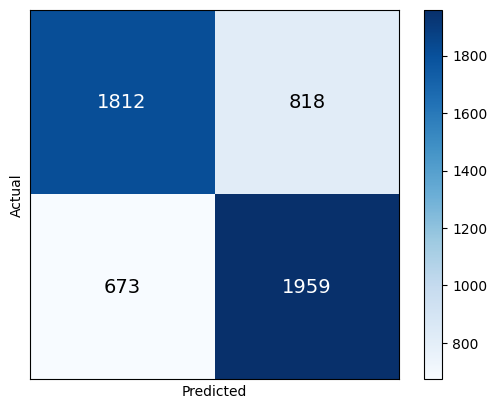

In [28]:
import matplotlib.pyplot as plt
# Create a figure and axis
fig, ax = plt.subplots()

# Display the confusion matrix as a table
cax = ax.matshow(cm, cmap='Blues')

# Remove x-axis and y-axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Add a colorbar
plt.colorbar(cax)

# Add labels with conditional font color
for i in range(2):
    for j in range(2):
        cell_value = cm[i][j]
        if i == 0 and j == 1:
            text_color = 'black'  # Change font color to black for [0][1]
        elif i == 1 and j == 0:
            text_color = 'black'  # Change font color to black for [1][0]
        else:
            text_color = 'white'  # Default font color (white)
        plt.text(j, i, str(cell_value), va='center', ha='center', fontsize=14, color=text_color)

# Show the plot
plt.show()

In [29]:
slovak_sentences = [
    "Dnes je krásny slnečný deň.",
    "Včera som čítal knihu v parku.",
    "Obľubujem dlhé prechádzky v prírode.",
    "toto je hlúpa lekcia",
    "nenávidím ťa vidieť plakať"
]
model.predict(slovak_sentences)

1/1 [==============================] - 0s 471ms/step


array([[0.2351198],
       [0.2351198],
       [0.2351198],
       [0.5874944],
       [0.4204124]], dtype=float32)